In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv003.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn
xarray = mre_pinn.utils.as_xarray

torch.cuda.is_available()

/ocean/projects/asc170022p/mtragoza/.conda/envs/MRE-PINN2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using backend: pytorch

Loading /ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks/../mre_pinn/__init__.py


True

In [3]:
%autoreload

# load the FEM box data set
data = mre_pinn.data.load_bioqic_fem_box_data('../data/BIOQIC')

# select data subset
data, ndim = mre_pinn.data.select_data_subset(
    data,
    downsample=False,
    frequency=80,
    x_slice=None,
    y_slice=75,
    z_slice=0
)

u  = data['u']
mu = data['mu']

data

Single frequency
1D


<xarray.Dataset>
Dimensions:    (frequency: 1, x: 80, component: 1)
Coordinates:
  * frequency  (frequency) float64 80.0
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
    y          float64 0.075
    z          float64 0.0
  * component  (component) <U1 'z'
Data variables:
    u          (frequency, x, component) complex128 (-2.0610768547282833e-06-...
    mu         (frequency, x) complex128 (3000+502.6548245743669j) ... (3000+...

In [4]:
%autoreload

# direct Helmholtz inversion via discrete laplacian

Lu = mre_pinn.discrete.laplacian(u, resolution=1e-3, dim=1)
data['Lu'] = Lu

#omega = u.frequency.expand_dims(u.dims[1:], axis=range(1, u.ndim)).to_numpy()
Mu = mre_pinn.discrete.helmholtz_inversion(u, Lu, u.frequency.to_numpy())
data['Mu'] = Mu


<IPython.core.display.Javascript object>


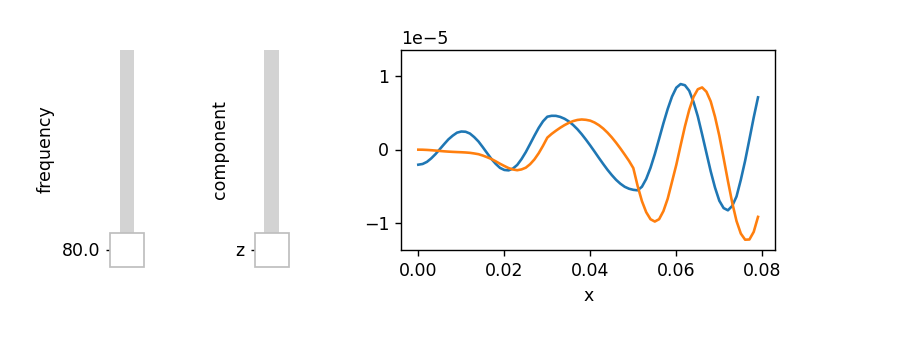

<IPython.core.display.Javascript object>


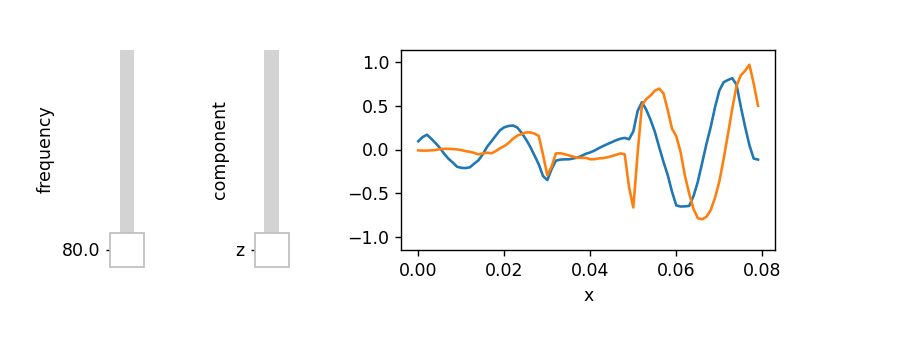

<IPython.core.display.Javascript object>


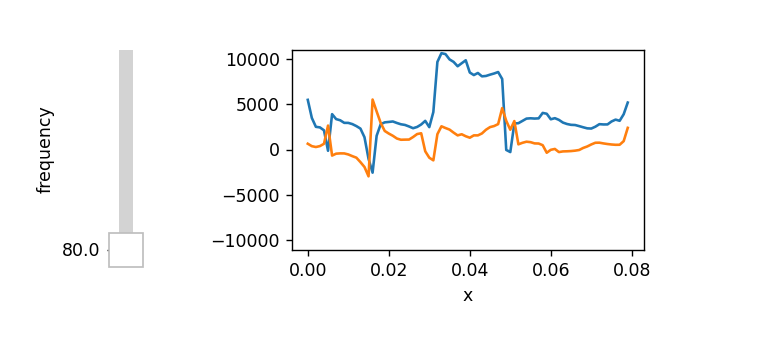

<IPython.core.display.Javascript object>


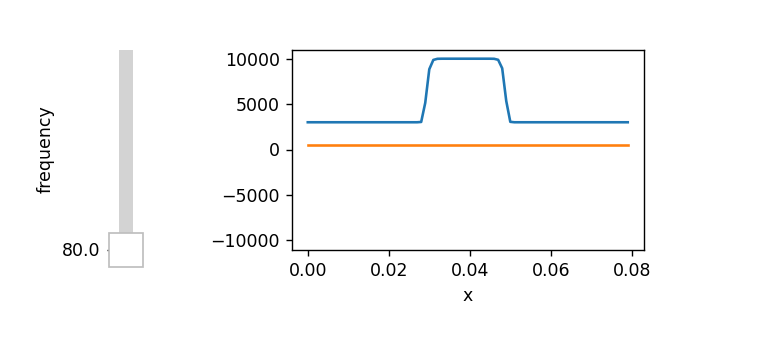

In [5]:
%autoreload

# configure color maps
pct = 100

w_map = mre_pinn.visual.wave_color_map()
w_max = np.percentile(np.abs(u), pct) * 1.1
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

L_max = np.percentile(np.abs(Lu), pct) * 1.1
laplace_kws = dict(cmap=w_map, vmin=-L_max, vmax=L_max)

e_map = mre_pinn.visual.elast_color_map()
e_max = np.percentile(np.abs(mu), pct) * 1.1
elast_kws = dict(cmap=e_map, vmin=-e_max, vmax=e_max)

# display true wave field and elastogram

x = 'x'
y = 'y' if ndim > 1 else None
hue = 'part'

mre_pinn.visual.XArrayViewer(u,  y=y, hue=hue, **wave_kws)
mre_pinn.visual.XArrayViewer(Lu, y=y, hue=hue, **laplace_kws)
mre_pinn.visual.XArrayViewer(Mu, y=y, hue=hue, **elast_kws)
mre_pinn.visual.XArrayViewer(mu, y=y, hue=hue, **elast_kws)

In [6]:
%autoreload

# create point set boundary condition

batch_size = 80 # training data points
u_bc = mre_pinn.data.XArrayBC(u, batch_size=batch_size)

#bc.points = bc.points.astype(np.complex128)

x = u_bc.points
u_true = u_bc.values
print('x     ', type(x), tuple(x.shape), x.dtype)
print('u_true', type(u_true), tuple(u_true.shape), u_true.dtype)

x      <class 'numpy.ndarray'> (80, 2) float32
u_true <class 'torch.Tensor'> (80, 1) torch.complex64


In [7]:
%autoreload

# set up PDE with geometry and boundary condition
wave_eq = mre_pinn.pde.WaveEquation(detach=True)

# need to add eps to singleton dimensions to avoid zero volume
eps = np.where(np.array(u.shape[:-1]) > 1, 0, 1e-5)

geometry = deepxde.geometry.Hypercube(x.min(axis=0), x.max(axis=0) + eps)
pde = deepxde.data.PDE(geometry, wave_eq, u_bc, num_domain=batch_size)

train_x = np.array(pde.train_x)
train_x.shape

/ocean/projects/asc170022p/mtragoza/.conda/envs/MRE-PINN2/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "


(160, 2)

In [31]:
%autoreload

# define model architecture

x = u_bc.points
u_true = u_bc.values
mu_true = mu.to_numpy().reshape(-1, 1)

net = mre_pinn.model.MRE_PINN(
    input=x,
    outputs=[u_true, mu_true],
    omega0=32,
    n_layers=2,
    n_hidden=1024,
    activ_fn='s',
    parallel=True,
    dense=True,
    dtype=torch.float32
)
u_bc.points = u_bc.points.astype(np.float32)

net

MRE_PINN(
  (0): InputScaler()
  (1): Parallel(
    (0): Feedforward(
      (linear0_sin): Linear(in_features=2, out_features=1024, bias=True)
      (linear1): Linear(in_features=1026, out_features=2, bias=True)
    )
    (1): Feedforward(
      (linear0_sin): Linear(in_features=2, out_features=1024, bias=True)
      (linear1): Linear(in_features=1026, out_features=2, bias=True)
    )
  )
  (2): RealToComplex()
  (3): OutputScaler()
)

In [ ]:
# descriptive statistics

kws = dict(axis=0, keepdims=True)

# standardize input to [-1, 1]
x = u_bc.points
x_loc = x.mean(**kws)
x_scale = (x.max(**kws) - x.min(**kws)) / 2
print('x', x_loc, x_scale)

# avoid division by zero
x_scale[x_scale == 0] = 1
x_s = (x - x_loc) / x_scale

# test forward pass
u_pred, mu_pred = torch.split(net(torch.as_tensor(x)), net.n_outputs, dim=1)
u_pred = u_pred.detach().cpu().numpy()
mu_pred = mu_pred.detach().cpu().numpy()

# normalize outputs via mean and std
u_true = u.to_numpy().reshape(-1, u.shape[-1])
u_loc = u_true.mean(**kws)
u_scale = u_true.std(**kws)
print('u', u_loc, u_scale)

u_true_s = (u_true - u_loc) / u_scale
u_pred_s = (u_pred - u_loc) / u_scale

mu_true = mu.to_numpy().reshape(-1, 1)
mu_loc = mu_true.mean(**kws)
mu_scale = mu_true.std(**kws)
print('mu', mu_loc, mu_scale)

mu_true_s = (mu_true - mu_loc) / mu_scale
mu_pred_s = (mu_pred - mu_loc) / mu_scale

# display input and output distributions

def plot_hist(ax, a, label):
    if np.iscomplexobj(a):
        a = mre_pinn.utils.as_real(a)
    sns.histplot(a, bins=20, ax=ax)
    ax.set_xlabel(label)
    ax.get_legend().set_frame_on(False)

fig, axes = plt.subplots(5, 2, figsize=(8, 8))

plot_hist(axes[0,0], x,   label='x')
plot_hist(axes[0,1], x_s, label='x_s')

plot_hist(axes[1,0], u_pred,   label='u_pred')
plot_hist(axes[1,1], u_pred_s, label='u_pred_s')

plot_hist(axes[2,0], u_true,   label='u_true')
plot_hist(axes[2,1], u_true_s, label='u_true_s')

plot_hist(axes[3,0], mu_pred,   label='mu_pred')
plot_hist(axes[3,1], mu_pred_s, label='mu_pred_s')

plot_hist(axes[4,0], mu_true,   label='mu_true')
plot_hist(axes[4,1], mu_true_s, label='mu_true_s')

fig.tight_layout()

x [[8.00e+01 3.95e-02]] [[0.     0.0395]]
u [[1.27296286e-07-9.91309226e-07j]] [[6.32981191e-06]]
mu [[4688.4460942+502.65482457j]] [[2916.84197377]]


<IPython.core.display.Javascript object>

In [33]:
%autoreload

pde.pde = mre_pinn.pde.WaveEquation(detach=True, homogeneous=True) # Helmholtz

# create normalized loss functions
u_norm = torch.norm(u_bc.values, dim=-1).mean().detach()
print(u_norm)

def normalized_L2_loss(norm):
    def loss_fn(y_true, y_pred):
        return torch.mean(
            (torch.norm(y_true - y_pred, dim=-1) / norm)
        )
    return loss_fn

loss = normalized_L2_loss(u_norm)

def predicted_L2_norm(idx, n):
    def norm(y_true, y_pred):
        return np.mean(
            np.linalg.norm(y_pred[:,idx:idx+n], axis=-1)
        )
    return norm

metrics = [
    predicted_L2_norm(net.idxs[i], n) for i, n in enumerate(net.n_outputs)
]

model = deepxde.Model(pde, net)
model.compile(
    optimizer='adam',
    lr=5e-4,
    loss_weights=[1e-8, 1],
    loss=loss,
    metrics=metrics,
)
batch_predict = mre_pinn.utils.minibatch(model.predict, batch_size)
batch_size

tensor(5.4517e-06)
Compiling model...
'compile' took 0.000130 s



80

Training model...



<IPython.core.display.Javascript object>


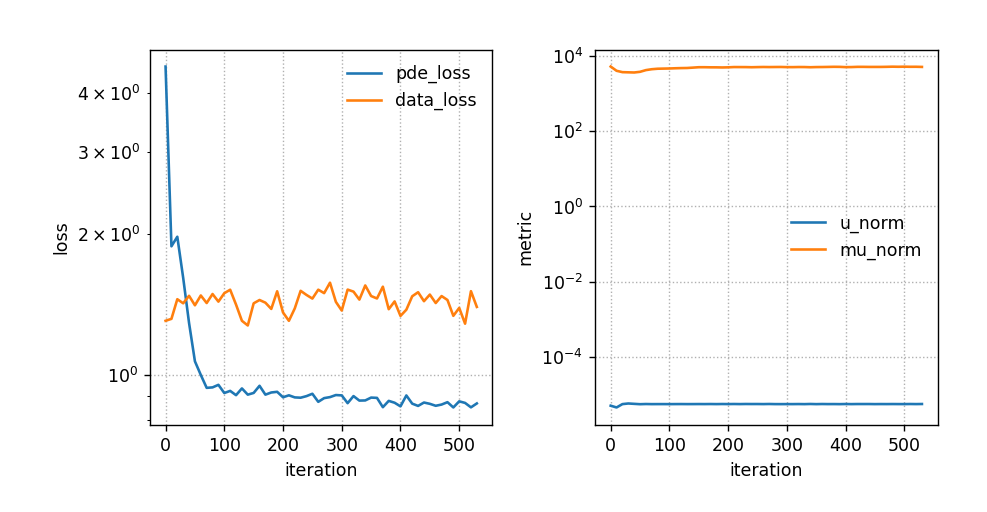

<IPython.core.display.Javascript object>


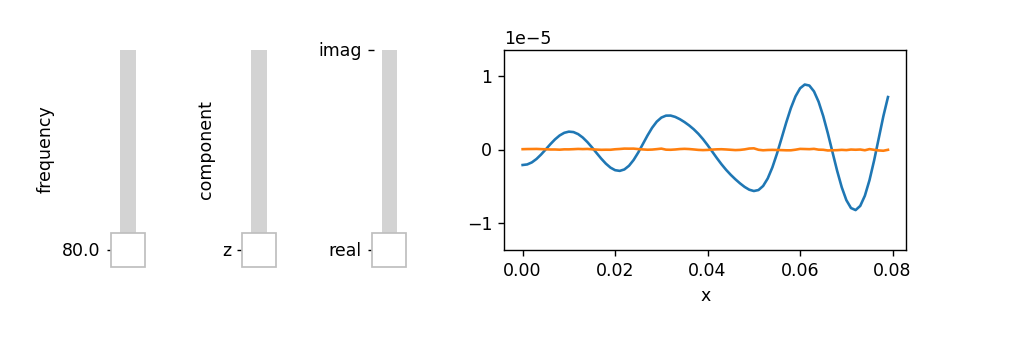

<IPython.core.display.Javascript object>


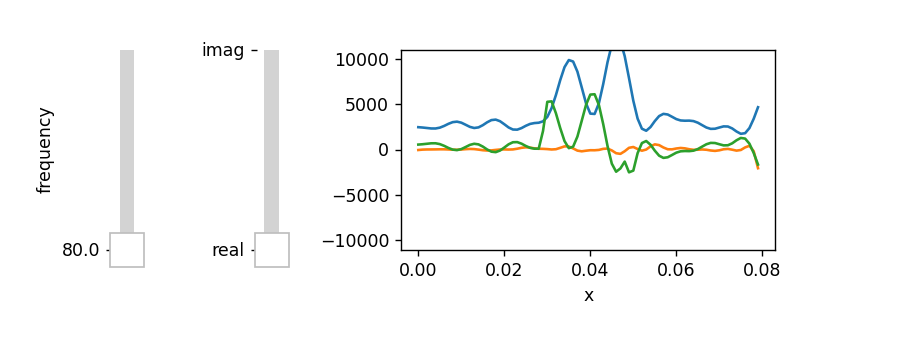

/ocean/projects/asc170022p/mtragoza/.conda/envs/MRE-PINN2/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
Interrupt


In [30]:
%autoreload

deepxde.display.training_display = mre_pinn.visual.TrainingPlot(
    losses=['pde_loss', 'data_loss'],
    metrics=['u_norm', 'mu_norm']
)

class PDEPointResampler(deepxde.callbacks.Callback):

    def on_batch_end(self):
        self.model.data.train_x_all = None
        self.model.data.train_x_bc = None
        self.model.data.resample_train_points()


class OutputViewer(deepxde.callbacks.Callback):
    
    def __init__(self, update_every, spectrum=False, residual=False):
        self.update_every = update_every
        self.spectrum = spectrum
        self.residual = residual
        super().__init__()
        
    def get_outputs(self):
        x = torch.as_tensor(self.model.data.bcs[0].points).requires_grad_(True)
        outputs = self.model.net(x)
        pde = model.data.pde(x, outputs).reshape(mu.shape).detach().cpu().numpy()
        u_pred, mu_pred = torch.split(outputs, net.n_outputs, dim=1)
        u_pred  = u_pred.detach().cpu().numpy().reshape(u.shape)
        mu_pred = mu_pred.detach().cpu().numpy().reshape(mu.shape)
        
        u_pred  = mre_pinn.utils.as_xarray(u_pred,  like=u)
        mu_pred = mre_pinn.utils.as_xarray(mu_pred, like=mu)
        pde = mre_pinn.utils.as_xarray(pde, like=mu)
         
        if self.spectrum: # TODO what if it's 1D?
            u_pred  = np.fft.fftshift(np.fft.fftn(u_pred,  axes=(1,2)), axes=(1,2))
            mu_pred = np.fft.fftshift(np.fft.fftn(mu_pred, axes=(1,2)), axes=(1,2))
            raise NotImplementedError

        elif self.residual:
            u_pred  = xr.concat([u_pred,  u - u_pred], dim='residual')
            mu_pred = xr.concat([mu_pred, pde, mu - mu_pred], dim='residual')

        return u_pred, mu_pred

    def on_train_begin(self):
        u_pred, mu_pred = self.get_outputs()
        self.u_viewer  = mre_pinn.visual.XArrayViewer(u_pred,  y=y, hue='residual', **wave_kws)
        self.mu_viewer = mre_pinn.visual.XArrayViewer(mu_pred, y=y, hue='residual', **elast_kws)

    def on_batch_end(self):
        if self.model.train_state.step % self.update_every != 0:
            return

        u_pred, mu_pred = self.get_outputs()
        self.u_viewer.update_array(u_pred)
        self.mu_viewer.update_array(mu_pred)

callbacks = [PDEPointResampler(), OutputViewer(update_every=1, spectrum=False, residual=True)]
try:
    model.train(1000, display_every=10, callbacks=callbacks)
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

In [ ]:
def laplacian_u(x, outputs):
    u = outputs[:,net.idxs[0]:net.idxs[1]]
    lu = mre_pinn.pde.laplacian(u, x, dim=1)
    deepxde.gradients.clear()
    return lu

# model predictions
x = u_bc.points
outputs = batch_predict(x)
u_pred, mu_pred = np.split(outputs, net.n_outputs[1:], axis=1)
u_pred = u_pred.reshape(u.shape)
mu_pred = mu_pred.reshape(mu.shape)

lu_pred = batch_predict(x, operator=laplacian_u)
lu_pred = lu_pred.reshape(u.shape)

u_pred  = mre_pinn.utils.as_xarray(u_pred,  like=u)
lu_pred = mre_pinn.utils.as_xarray(lu_pred, like=u)
mu_pred = mre_pinn.utils.as_xarray(mu_pred, like=mu)

In [ ]:
%autoreload

# display wave fields
mre_pinn.visual.XArrayViewer(
    xr.concat([u_pred, u - u_pred, u], dim='which'), y=y, hue='which', **wave_kws
)

In [ ]:
# display wave field Laplacians

Lu_true = mre_pinn.discrete.laplacian(u_true, resolution=1e-3, dim=1)
Lu_pred = mre_pinn.discrete.laplacian(u_pred, resolution=1e-3, dim=1)

mre_pinn.visual.XArrayViewer(
    xr.concat([lu_pred, lu_pred - Lu, Lu], dim='which'), y=y, hue='which', **laplace_kws
)

In [ ]:
%autoreload

# display reconstructed elastograms

omega = u.frequency.to_numpy().reshape(-1, 1, 1)
mu_data = mre_pinn.discrete.helmholtz_inversion(u, Lu_true, omega) #.mean(axis=0)
mu_u_Lu = mre_pinn.discrete.helmholtz_inversion(u_pred, Lu_pred, omega) #.mean(axis=0)
mu_u_lu = mre_pinn.discrete.helmholtz_inversion(u_pred, lu_pred, omega) #.mean(axis=0)
#mu_pred = mre_pinn.discrete.helmholtz_inversion(u_pred, lu_model, omega)

mre_pinn.visual.XArrayViewer(
    xr.concat([mu_pred, mu_pred - mu, mu], dim='which'), y=y, hue='which', **elast_kws
)

<IPython.core.display.Javascript object>


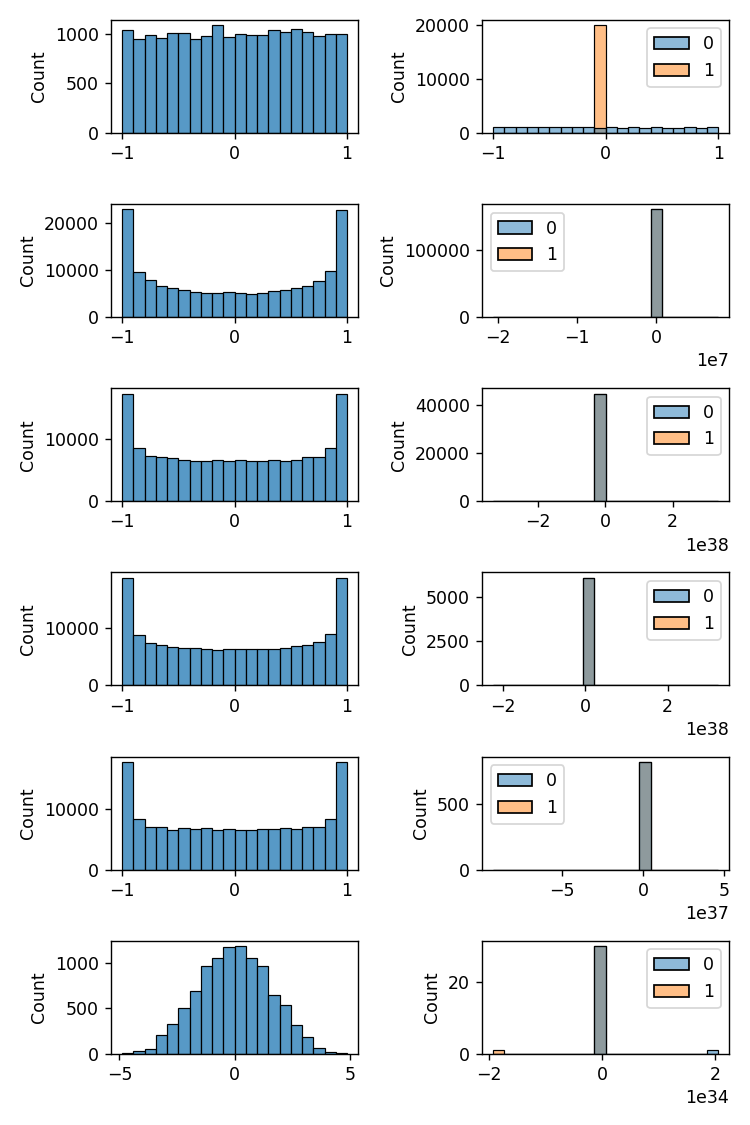

In [9]:
# try out complex initialization schemes

def runiform(n, scale=1):
    return (2 * torch.rand(n) - 1) * scale

def cuniform(n, scale=1):
    radius = torch.rand(n) * scale 
    angle  = torch.rand(n) * 2 * np.pi
    return radius * torch.exp(1j * angle)

n = 10000
d = 2
layers = [16, 16, 16, 16]
sin = torch.sin
cis = lambda x: torch.cos(x) + 1j * torch.sin(x)
gas = lambda x: torch.exp(-x**2)
wav = lambda x: cis(x) * gas(x)

fig, axes = plt.subplots(len(layers) + 2, 2, figsize=(6, 1.5*(len(layers) + 2)), squeeze=False)

def plot_hist(ax, a):
    a = a.detach().cpu().numpy().flatten()
    if np.iscomplexobj(a):
        a = mre_pinn.utils.as_real(a, interleave=False)
    sns.histplot(a, bins=20, ax=ax, legend=True)

a = runiform((n, d))
b = runiform((n, d)) + 0j
plot_hist(axes[0,0], a)
plot_hist(axes[0,1], b)

for i, w in enumerate(layers):
    if i == 0:
        a_scale = 32 / d
        b_scale = 32 / d
    else:
        a_scale = np.sqrt(6 / d)
        b_scale = np.sqrt(6 / d)
    a = sin(a @ runiform((d, w), a_scale))
    b = cis(b @ cuniform((d, w), b_scale))
    plot_hist(axes[i+1,0], a)
    plot_hist(axes[i+1,1], b)
    d = w

a = a @ runiform((d, 1))
b = b @ cuniform((d, 1))
plot_hist(axes[-1,0], a)
plot_hist(axes[-1,1], b)
fig.tight_layout()